Use the posterior predictive distribution for predicting the future results of tossing the same coin.
Bernoulli data (1000 trials, true p=0.23) is combined with Beta prior (p=0.23).

5 possible numbers of pseudo-trials are tested. These form a geometric progression with factor 5, and ensure that the prior changes from weaker to stronger than the data. The mean and Standard Deviation of each posterior predictive sample is computed, and its histogram is plotted.

-----------------

Results. As expected, the mean of posterior predictive samples moves monotonically from the proportion of success in data to the parameter of prior distribution.
As expected, the decrease of Standard Deviation is monotonic. On the other hand, its decrease is quite slow.

In [1]:
# imports

# for generating the numbers of pseudo-trials 
from functools import partial
from operator import pow

import matplotlib.pyplot as plt
import seaborn as sns

# import arviz as az
import pymc as pm

from scipy.stats import bernoulli

Generate data

In [2]:
RANDOM_SEED = 4000
weakest_nb_pseudo_trials = 100

In [3]:
weakest_alpha = 23
weakest_beta = weakest_nb_pseudo_trials -weakest_alpha  # 77
true_p = weakest_alpha / weakest_nb_pseudo_trials  # 0.23

trials = 1000
ex_bernoulli = bernoulli.rvs(true_p, size=trials, random_state=RANDOM_SEED)
successes = ex_bernoulli.sum()
print("The true number of successes is", successes, "out of", trials, "trials")
# 224 out of 1000

The true number of successes is 224 out of 1000 trials


Function for generating the model.

In [4]:
# Model in a function
def create_model(multiplier_strength_prior: int):
    """
    Generates a PyMC model with Beta prior of prior probability of success equal 'true_p' above.
    The number of pseudo-successes and pseudo-failures are proportional to
    (weakest_alpha, weakest_beta )
    with the coefficient 'multiplier_strength_prior' .
    
    Args:
        multiplier_strength_prior (int): the coefficient, which determines the number of pseudo-trials and strength of the prior.

    Returns: PyMC model with Beta prior and observed data generated above.
    """
    with pm.Model() as model:    
        p = pm.Beta("p", alpha=multiplier_strength_prior * weakest_alpha, beta=multiplier_strength_prior * weakest_beta)
        # see: https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Beta.html
        
        obs = pm.Binomial("y", n=trials, p=p, observed=successes)
    return model

Loop over the strengths of prior distribution. The following instructions SHOULD BE checked, then moved inside the loop. 

In [5]:
log_multipliers = range(5)
fun5pow = partial(pow, 5)
multipliers_prior = list(map(fun5pow, log_multipliers))
# [1, 5, 25, 125, 625]

In [6]:
%%time

# These lists will store the numeric results (stats of computed distributions). 
posterior_means = []
posterior_std = []
predictive_means = []
predictive_std = []

posterior_predictive_distr = [] # This list will store the Series of posterior predictive sampling distributions.

# Main loop.
for multiplier in multipliers_prior:
    model = create_model(multiplier)
    with model:
        idata = pm.sample(random_seed=42)

    with model:
        idata.extend(pm.sample_posterior_predictive(idata, random_seed=35))

    df_idata_full = idata.to_dataframe()

    # posterior distribution
    arr_posterior = df_idata_full[('posterior', 'p')]  # Series
    posterior_means.append(arr_posterior.mean())
    posterior_std.append(arr_posterior.std())
    
    # predictive posterior
    arr_predictive_posterior = df_idata_full[('posterior_predictive', 'y')] / trials
    
    posterior_predictive_distr.append(arr_predictive_posterior)
    
    predictive_means.append(arr_predictive_posterior.mean())
    predictive_std.append(arr_predictive_posterior.std())

# Print the results.
print(posterior_means)
print("--------")
print(posterior_std)
print("--------")
print(predictive_means)
print("--------")
print(predictive_std)
print("--------")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [y]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [y]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [y]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [y]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [y]


[0.22453897639336304, 0.2257359826622956, 0.22822094873441032, 0.2294452950307126, 0.22989096789270444]
--------
[0.012621731998766964, 0.010551039908976163, 0.007049538693832051, 0.0036511995200709064, 0.0016751561595287452]
--------
[0.22451825000000003, 0.22570775000000004, 0.22821424999999998, 0.22951075, 0.2298745]
--------
[0.01817855279946593, 0.01711958264575954, 0.015142049641786894, 0.01396331364574657, 0.01352264638453991]
--------
CPU times: user 16 s, sys: 613 ms, total: 16.6 s
Wall time: 32.5 s


The prior becomes stronger in each model (reinforced by factor of 5 each time). The mean of the posterior sample moves from 0.224 (data) to 0.23 (prior), while the Standard Deviation shows a monotonic decrease.  

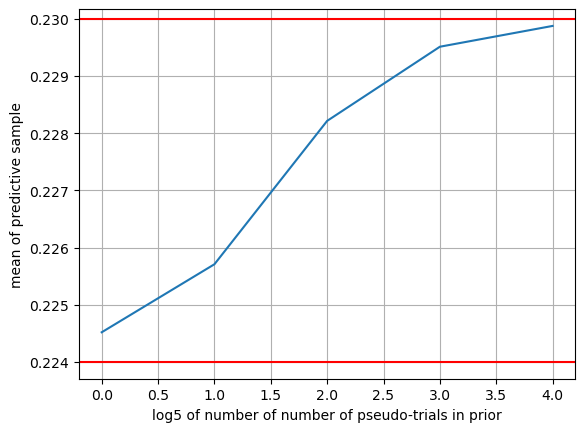

In [7]:
# Plot posterior predictive mean

plt.plot(log_multipliers, predictive_means)
plt.grid(True)
plt.xlabel('log5 of number of number of pseudo-trials in prior')
plt.ylabel('mean of predictive sample')
plt.axhline(successes / trials, color="red")
plt.axhline(true_p, color="red")
plt.show()

Text(0, 0.5, 'SD of predictive sample')

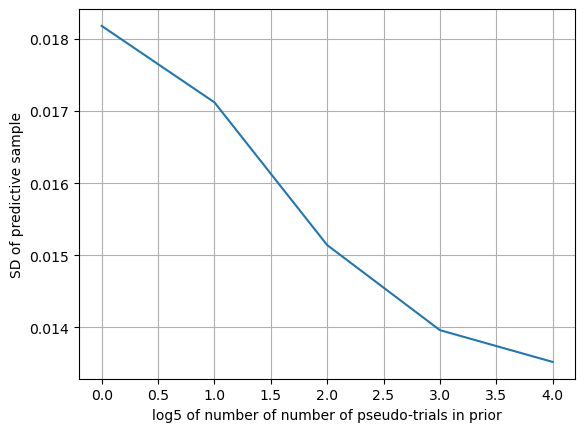

In [8]:
#  plot standard deviation
plt.plot(log_multipliers, predictive_std)
plt.grid(True)
plt.xlabel('log5 of number of number of pseudo-trials in prior')
plt.ylabel('SD of predictive sample')


[<Axes: xlabel="('posterior_predictive', 'y')", ylabel='Count'>,
 <Axes: xlabel="('posterior_predictive', 'y')", ylabel='Count'>,
 <Axes: xlabel="('posterior_predictive', 'y')", ylabel='Count'>,
 <Axes: xlabel="('posterior_predictive', 'y')", ylabel='Count'>,
 <Axes: xlabel="('posterior_predictive', 'y')", ylabel='Count'>]

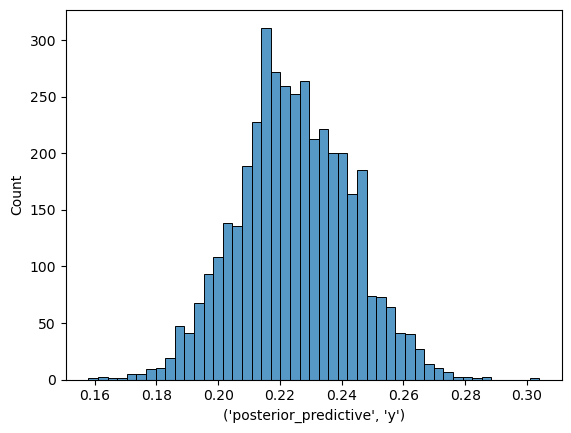

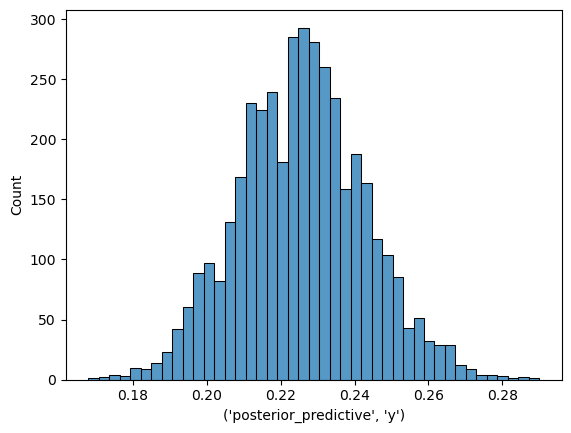

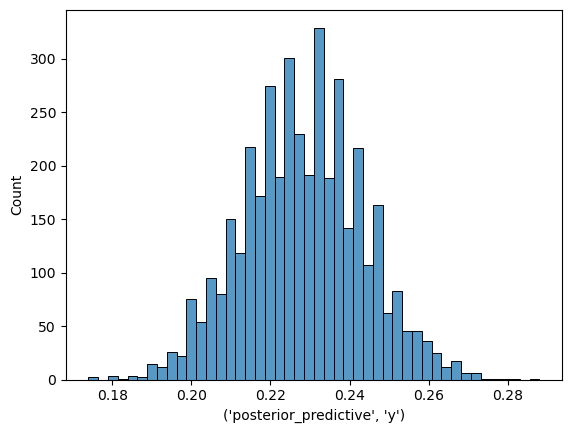

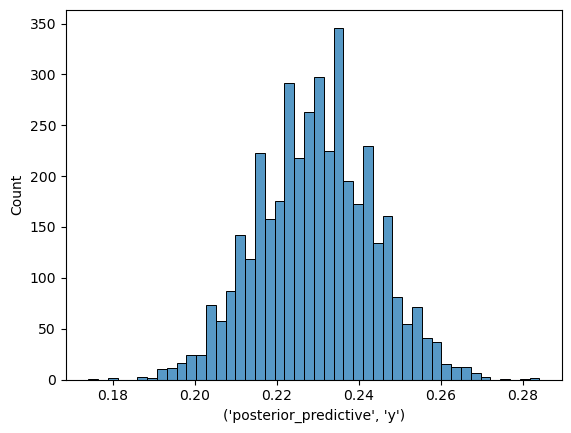

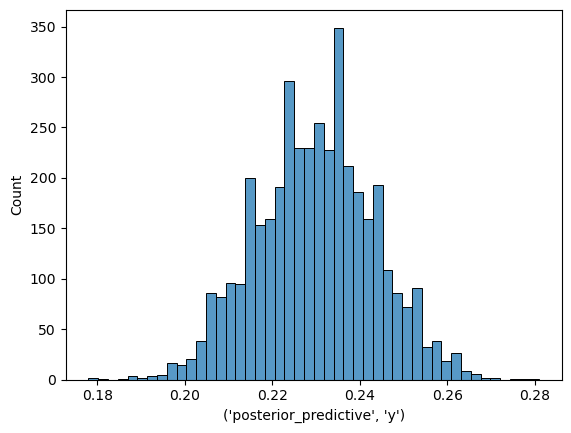

In [9]:
# Plot posterior predictive distributions 

def plot_series(in_series):
    __, ax = plt.subplots()
    sns.histplot(in_series, ax=ax)
    return ax
    
list(map(plot_series, posterior_predictive_distr))

These 5 histograms look similar enough. Careful examination allows concluding that extreme values become rare in the latest histograms.